In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('BTC_h_2021.csv')

In [3]:
df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2021-07-01 00:00:00+00:00,35035.984375,35035.984375,34746.261719,34749.640625,34749.640625,0
1,2021-07-01 01:00:00+00:00,34736.515625,34986.546875,34732.746094,34952.367188,34952.367188,554323968
2,2021-07-01 02:00:00+00:00,34945.632812,34945.632812,34267.609375,34334.437500,34334.437500,808083456
3,2021-07-01 03:00:00+00:00,34330.417969,34392.886719,34168.179688,34197.546875,34197.546875,0
4,2021-07-01 04:00:00+00:00,34168.027344,34331.566406,34109.277344,34331.566406,34331.566406,0
...,...,...,...,...,...,...,...
16941,2023-06-15 23:00:00+00:00,25606.259766,25612.388672,25537.435547,25576.632812,25576.632812,0
16942,2023-06-16 00:00:00+00:00,25575.283203,25575.283203,25433.914062,25478.167969,25478.167969,22113280
16943,2023-06-16 01:00:00+00:00,25476.232422,25554.261719,25443.478516,25497.904297,25497.904297,24245248
16944,2023-06-16 02:00:00+00:00,25497.773438,25530.468750,25471.746094,25526.515625,25526.515625,59495424


In [4]:
data = df['Close'].values

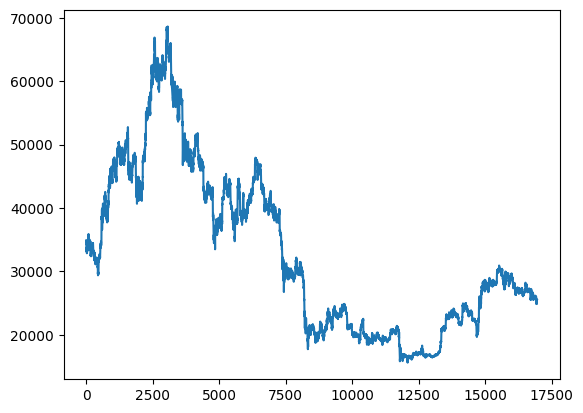

In [5]:
plt.plot(data)

In [6]:
def SMA(n , dat):
    sma_list = [0] * (n-1)
    for i in range(n, dat.shape[0]+1):
        sma_list.append(np.mean(dat[i-n:i]))
    return(sma_list)

In [28]:
def CUTS(sma1 , sma2): # sma1 shorter than sma2
    buy = []
    sell = []
    old = 1
    for i in range(len(sma1)):
        if (sma1[i]>=sma2[i]):
            new = 1
        else:
            new = -1
        if (old != new):
            if (new==-1) :
                sell.append(i)
            else:
                buy.append(i)
        old = new
    return buy , sell

In [37]:
def PROFITS (buys , sells , data):
    l = 5
    profit = []
    if (len(buys)>0):
        if buys[0] > sells[0]:
            for i in range(len(buys)-1):
                p =  (data[sells[i]] - data[buys[i]])/data[buys[i]]*l
                profit.append(p)
                p = (data[sells[i+1]] - data[buys[i]])/data[buys[i]]*l
                profit.append(p)
        else :
            for i in range(len(buys)):
                p = (data[sells[i]] - data[buys[i]])/data[buys[i]]*l
                profit.append(p)
    return profit

In [53]:
def RATE(profs):
    fees = 0.999
    if (len(profs)>0):
        numtrades = len(profs)
        maxdrawdown = min(profs) 
        maxwin = max(profs)
        allprofit = 1
        multiplyer = [1] # your money in time
        for i in profs:
            multiplyer.append(allprofit * (1 + i) * fees)
            allprofit = allprofit * (1 + i)*fees
        return numtrades , maxdrawdown , maxwin , allprofit , multiplyer
    else:
        return 0 , 0 , 0 , 1 , [1]

In [59]:
N = 8000 #time
m = 24*2 # mas

smas = np.zeros((m , N) , dtype = float)
for i in range (m):
    smas [i , :] = SMA(i+1 , data[-N:])
    
numtradess = np.zeros((m , m) , dtype = float )
maxdrawdowns = np.zeros((m , m) , dtype = float )
maxwins = np.zeros((m , m) , dtype = float )
allprofits = np.zeros((m , m) , dtype = float )
multiplyers = np.ones((m , m , N) , dtype = float )



for i in range (m):
    for j in range (m):
        if (i<j):
            buys , sells = CUTS(smas[i , :] , smas[j , :])
            profits = PROFITS(buys , sells , data[-N:])
            numtradess[i][j] , maxdrawdowns[i][j] , maxwins[i][j] , allprofits[i][j] , multiplyers[i , j , 0:(len(buys)*2-1)] = RATE (profits)
        if (j<i):
            buys , sells = CUTS(smas[j , :] , smas[i , :])
            profits = PROFITS(buys , sells , data[-N:])
            numtradess[i][j] , maxdrawdowns[i][j] , maxwins[i][j] , allprofits[i][j] , multiplyers[i , j , 0:(len(buys)*2-1)] = RATE (profits)

In [60]:
np.max(allprofits)

93.0472328637051

In [61]:
maxrow, maxcol = np.unravel_index(np.argmax(allprofits), allprofits.shape)
print("Best combination: " + str(maxrow) + " , " + str(maxcol))

Best combination: 13 , 18


In [62]:
allprofits[16][20]

34.27673906640589

In [63]:
maxdrawdowns[16][20]

-0.280766239956439

In [49]:
buy , sell = CUTS(smas[16 , :] , smas[22 , :])
profits = PROFITS(buy , sell, data[-N:])

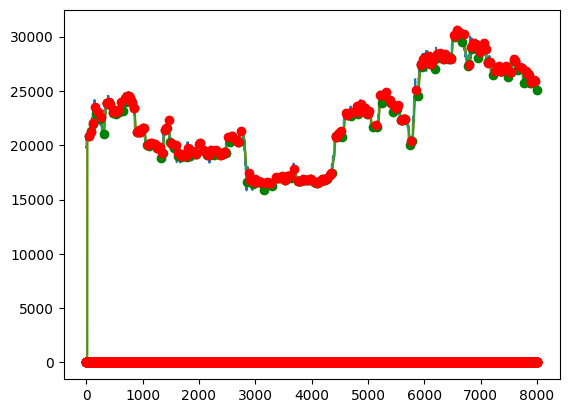

In [50]:
plt.plot(data[-N:])
plt.plot(smas[16 , :])
plt.plot(smas[22 , :])
t = np.linspace(0 , N , num = N)
buys = np.zeros(N)
sells = np.zeros(N)
for i in range(N):
    if i in buy:
        buys[i] = smas[22 , i]
    if i in sell:
        sells[i] = smas[22 , i]
plt.plot(t , buys , 'o' , color = 'green')
plt.plot(t , sells , 'o' , color = 'red')

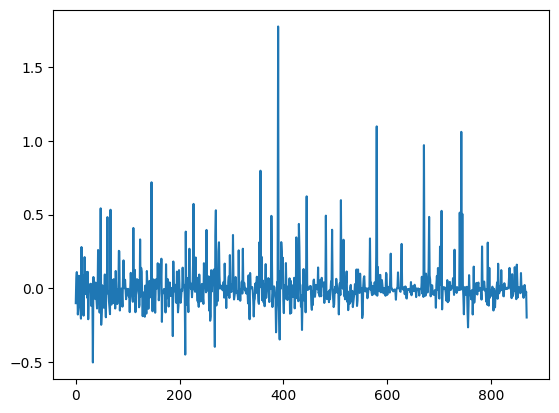

In [17]:
x = np.linspace(0 , len(profits), num = len(profits))
plt.plot(profits)

In [18]:
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)

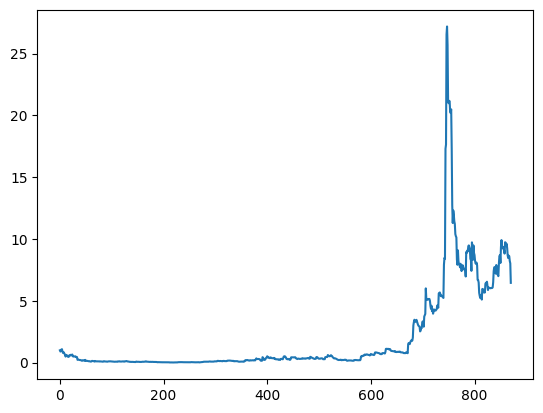

In [19]:
x = np.linspace(0 , len(multiplyer), num = len(multiplyer))
plt.plot(multiplyer)

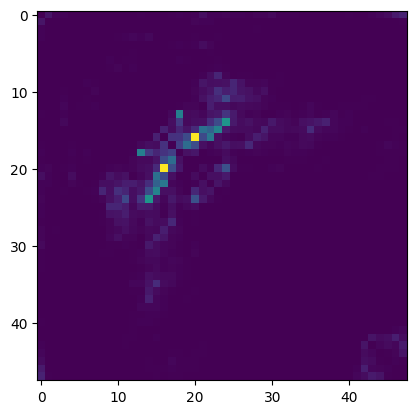

In [20]:
plt.imshow(allprofits)

In [22]:
numtradess[16][20]

1072.0

In [23]:
allactions = np.concatenate((buy, sell))

allactions = np.sort(allactions)

interval = np.diff(allactions)

avgtradetime = np.mean(interval)
avgtradeprofit = np.mean(profits)

In [24]:
print("The best model finished training with avrage trade time of " + str(avgtradetime) + " and avrage profit of " + str(avgtradeprofit))

The best model finished training with avrage trade time of 18.33409873708381 and avrage profit of 0.01158503318293286


In [25]:
flattened_arr = allprofits.flatten()

# Get the indexes of the 20 largest numbers
indexes = np.argpartition(flattened_arr, -20)[-20:]

# Convert flat indexes to row and column indexes
row_indexes, col_indexes = np.unravel_index(indexes, allprofits.shape)

In [26]:
row_indexes

array([14, 16, 23, 23, 17, 24, 20, 18, 15, 21, 13, 15, 19, 15, 22, 22, 24,
       14, 16, 20])

In [27]:
col_indexes

array([23, 22, 14, 15, 19, 20, 24, 13, 23, 15, 18, 22, 17, 21, 16, 15, 14,
       24, 20, 16])